In [1]:
import json
import string
from pathlib import Path

import cairosvg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skunk
import yaml
from coulson.draw import draw_mol
from matplotlib.offsetbox import AnnotationBbox
from rdkit import Chem
from sklearn.linear_model import LinearRegression
from utils import (
    PARENT_SMILES,
    SCAFFOLD_NAMES,
    add_to_variables,
    crop_image,
    format_dictionary_for_yaml,
    load_data,
    plot_zero_zero,
)

plt.style.use("default")

Define variables and parameters

In [2]:
params = {}
variables = {}

Read data

In [3]:
data_csv = snakemake.input.data
ref_csv = snakemake.input.reference

df_rational = load_data(data_csv, ref_csv)
df_rational["scaffold"] = [idx.split("_")[0] for idx in df_rational.index]

Calculate number and percentage of failed

In [ ]:
n_failed = df_rational.isna().any(axis=1).sum()
n_total = df_rational.shape[0]
percent_success = (n_total - n_failed) / n_total * 100
variables["global_n_total"] = n_total
variables["global_n_failed"] = n_failed
variables["global_percent_success"] = f"{percent_success:.2f}"

# Remove the nans for further processing
df_rational.dropna(inplace=True)

Fit linear correction


In [4]:
lr = LinearRegression()
lr.fit(df_rational[["t1_s1_dsp_cis"]], df_rational["t1_s1_ref"])

df_rational["t1_s1_dsp_cis_corr"] = (
    df_rational["t1_s1_dsp_cis"] * lr.coef_ + lr.intercept_
)
variables["global_lc_coef"] = lr.coef_[0]
variables["global_lc_intercept"] = lr.intercept_
print(f"Coefficient: {lr.coef_[0]}")
print(f"Intercept: {lr.intercept_}")

with open(snakemake.output.corr, "w") as f:
    json.dump({"Coefficient": lr.coef_[0], "Intercept": lr.intercept_}, f)

Coefficient: 0.5264406639610293
Intercept: -0.15297587583336736


Plot gaps

t1_s1_dsp_scf
t1_s1_dsp_cis
t1_s1_dsp_cis_corr


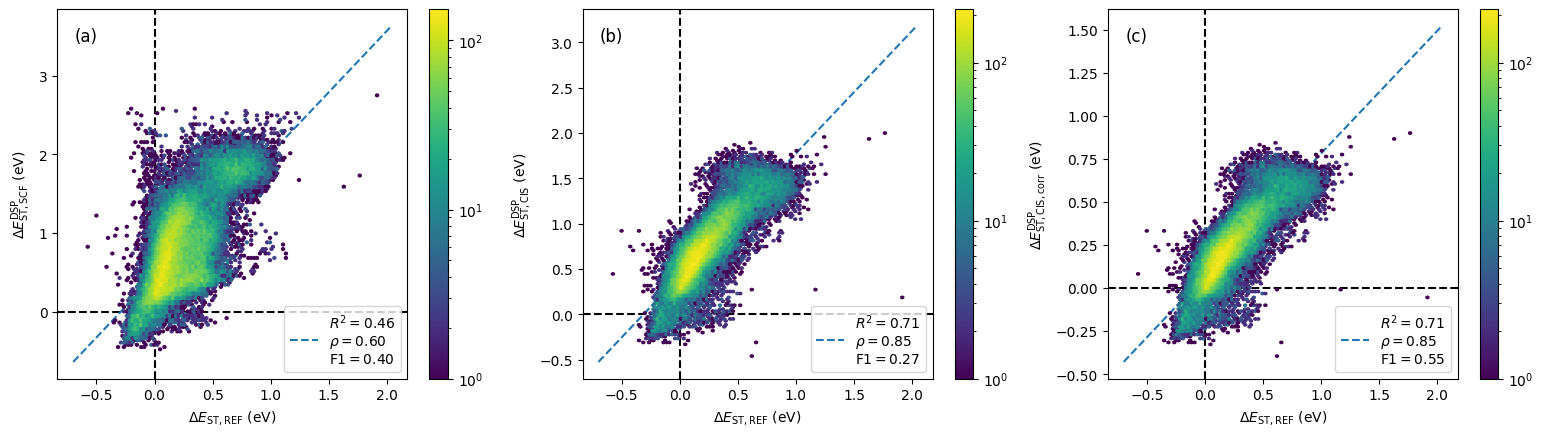

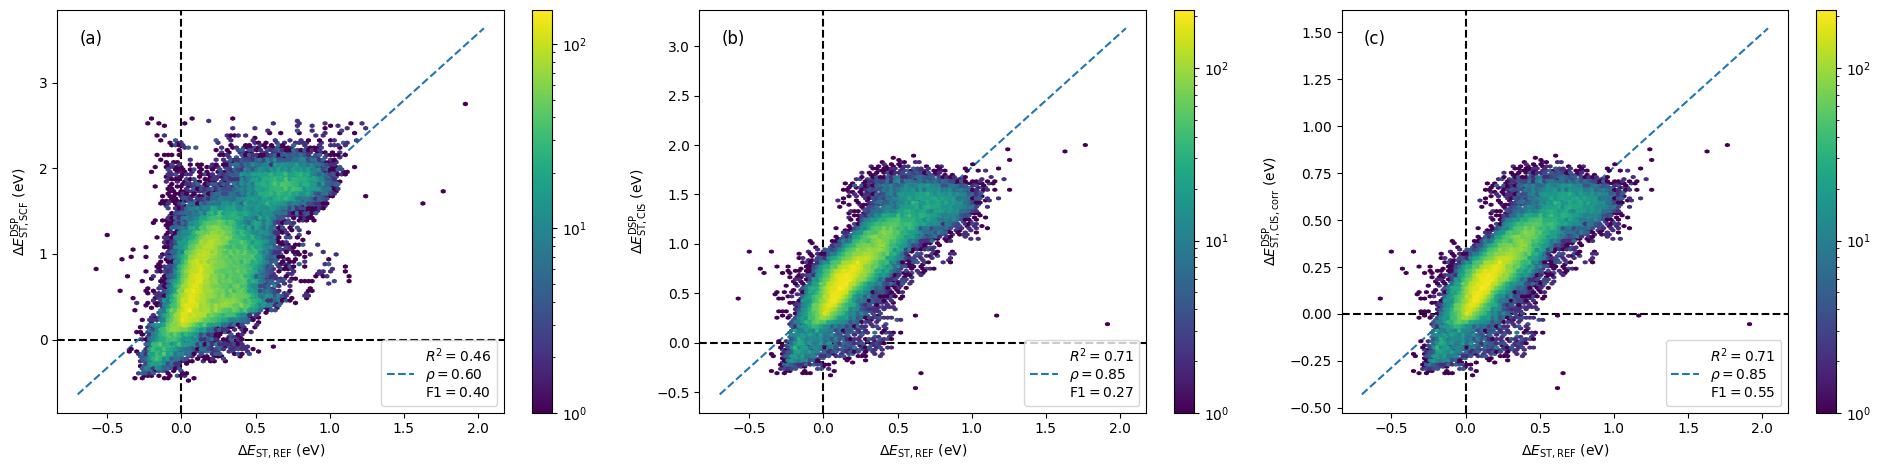

In [5]:
plot_kwargs = {}
x_name = "t1_s1_ref"


all_results = {}
label_calculation = "global"

jobs = (
    ("SCF + DSP", "scf", "t1_s1_dsp_scf"),
    ("CIS + DSP", "cis", "t1_s1_dsp_cis"),
    ("CIS + DSP + LC", "cis_corr", "t1_s1_dsp_cis_corr"),
)

fig, ax = plt.subplots(1, 3, figsize=plt.rcParams["figure.figsize"] * np.array([3, 1]))

# Create subfigure labels
for i, ax_ in enumerate(ax):
    label = string.ascii_lowercase[i]
    ax_.text(
        0.05,
        0.95,
        f"({label})",
        fontsize="large",
        transform=ax_.transAxes,
        verticalalignment="top",
    )

for i, (label_plot, label_method, y_name) in enumerate(jobs):
    print(y_name)

    _, _, results = plot_zero_zero(
        df_rational,
        x_name=x_name,
        y_name=y_name,
        plot_type="hexbin",
        **plot_kwargs,
        ax=ax[i],
        legend_loc="lower right",
    )
    ax[i].set_label(label_plot)
    variables = add_to_variables(
        variables,
        results,
        label_calculation=label_calculation,
        label_compound="all",
        label_method=label_method,
    )
    all_results[label_plot] = results
display(fig)
fig.tight_layout()
path_figure = snakemake.output.figure_global_all_gaps
variables[f"fig_global_all_gaps"] = "../" + str(Path(path_figure).with_suffix(""))
fig.savefig(path_figure)

# Add parameters to be saved
path_table = snakemake.output.table_global_all_gaps
params[f"tab_global_all_gaps"] = "../" + path_table

# Print tables for the paper
df = pd.DataFrame(all_results).T
floatfmt = [None] + [".2f"] * (len(results) - 4) + [".0f"] * 4
df.to_markdown(path_table, floatfmt=floatfmt)

Plot excitation energies and oscillator strengths

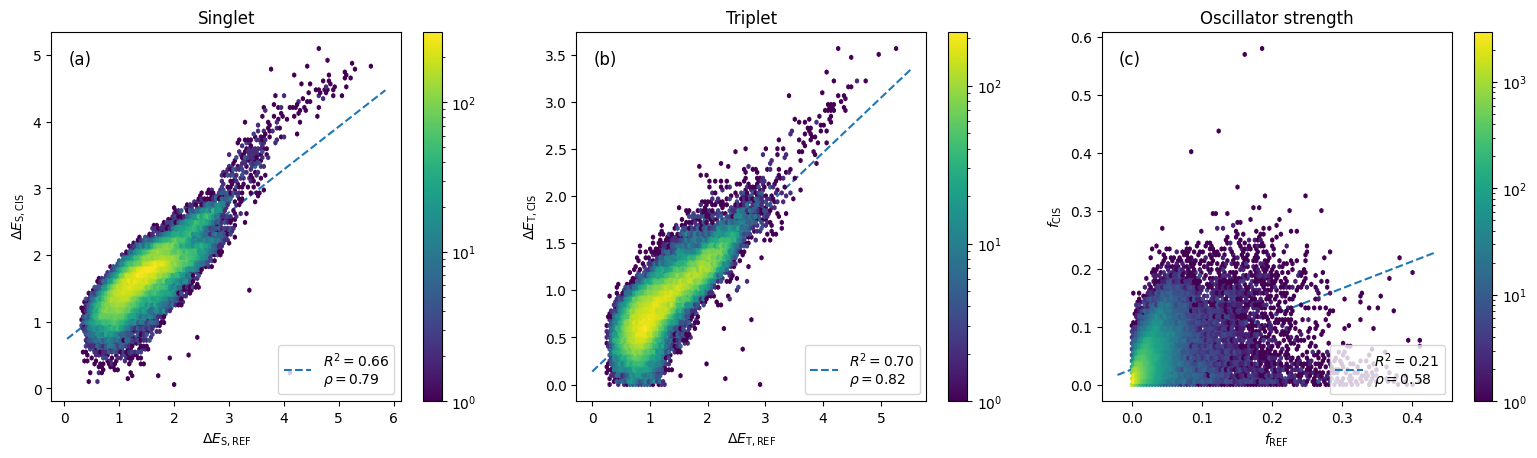

In [6]:
fig, ax = plt.subplots(1, 3, figsize=plt.rcParams["figure.figsize"] * np.array([3, 1]))

# Create subfigure labels
for i, ax_ in enumerate(ax):
    label = string.ascii_lowercase[i]
    ax_.text(
        0.05,
        0.95,
        f"({label})",
        fontsize="large",
        transform=ax_.transAxes,
        verticalalignment="top",
    )

_, _, results = plot_zero_zero(
    df_rational,
    x_name="s1_ref",
    y_name="s1_cis",
    plot_type="hexbin",
    zero_zero=False,
    **plot_kwargs,
    ax=ax[0],
    legend_loc="lower right",
)
ax[0].set_title("Singlet")

variables = add_to_variables(
    variables,
    results,
    label_calculation=label_calculation,
    label_compound="all",
    label_method="singlet",
)

# Plot triplet
_, _, results = plot_zero_zero(
    df_rational,
    x_name="t1_ref",
    y_name="t1_cis",
    plot_type="hexbin",
    zero_zero=False,
    **plot_kwargs,
    ax=ax[1],
    legend_loc="lower right",
)
ax[1].set_title("Triplet")
variables = add_to_variables(
    variables,
    results,
    label_calculation=label_calculation,
    label_compound="all",
    label_method="triplet",
)

# Plot oscillator strength
_, _, results = plot_zero_zero(
    df_rational,
    x_name="oscillator_strength_ref",
    y_name="oscillator_strength",
    plot_type="hexbin",
    zero_zero=False,
    **plot_kwargs,
    ax=ax[2],
    legend_loc="lower right",
)
ax[2].set_title("Oscillator strength")
variables = add_to_variables(
    variables,
    results,
    label_calculation=label_calculation,
    label_compound="all",
    label_method="oscillator",
)

path_figure = snakemake.output.figure_global_all
variables[f"fig_global_all"] = "../" + str(Path(path_figure).with_suffix(""))
fig.savefig(path_figure)

Plot gaps per scaffold

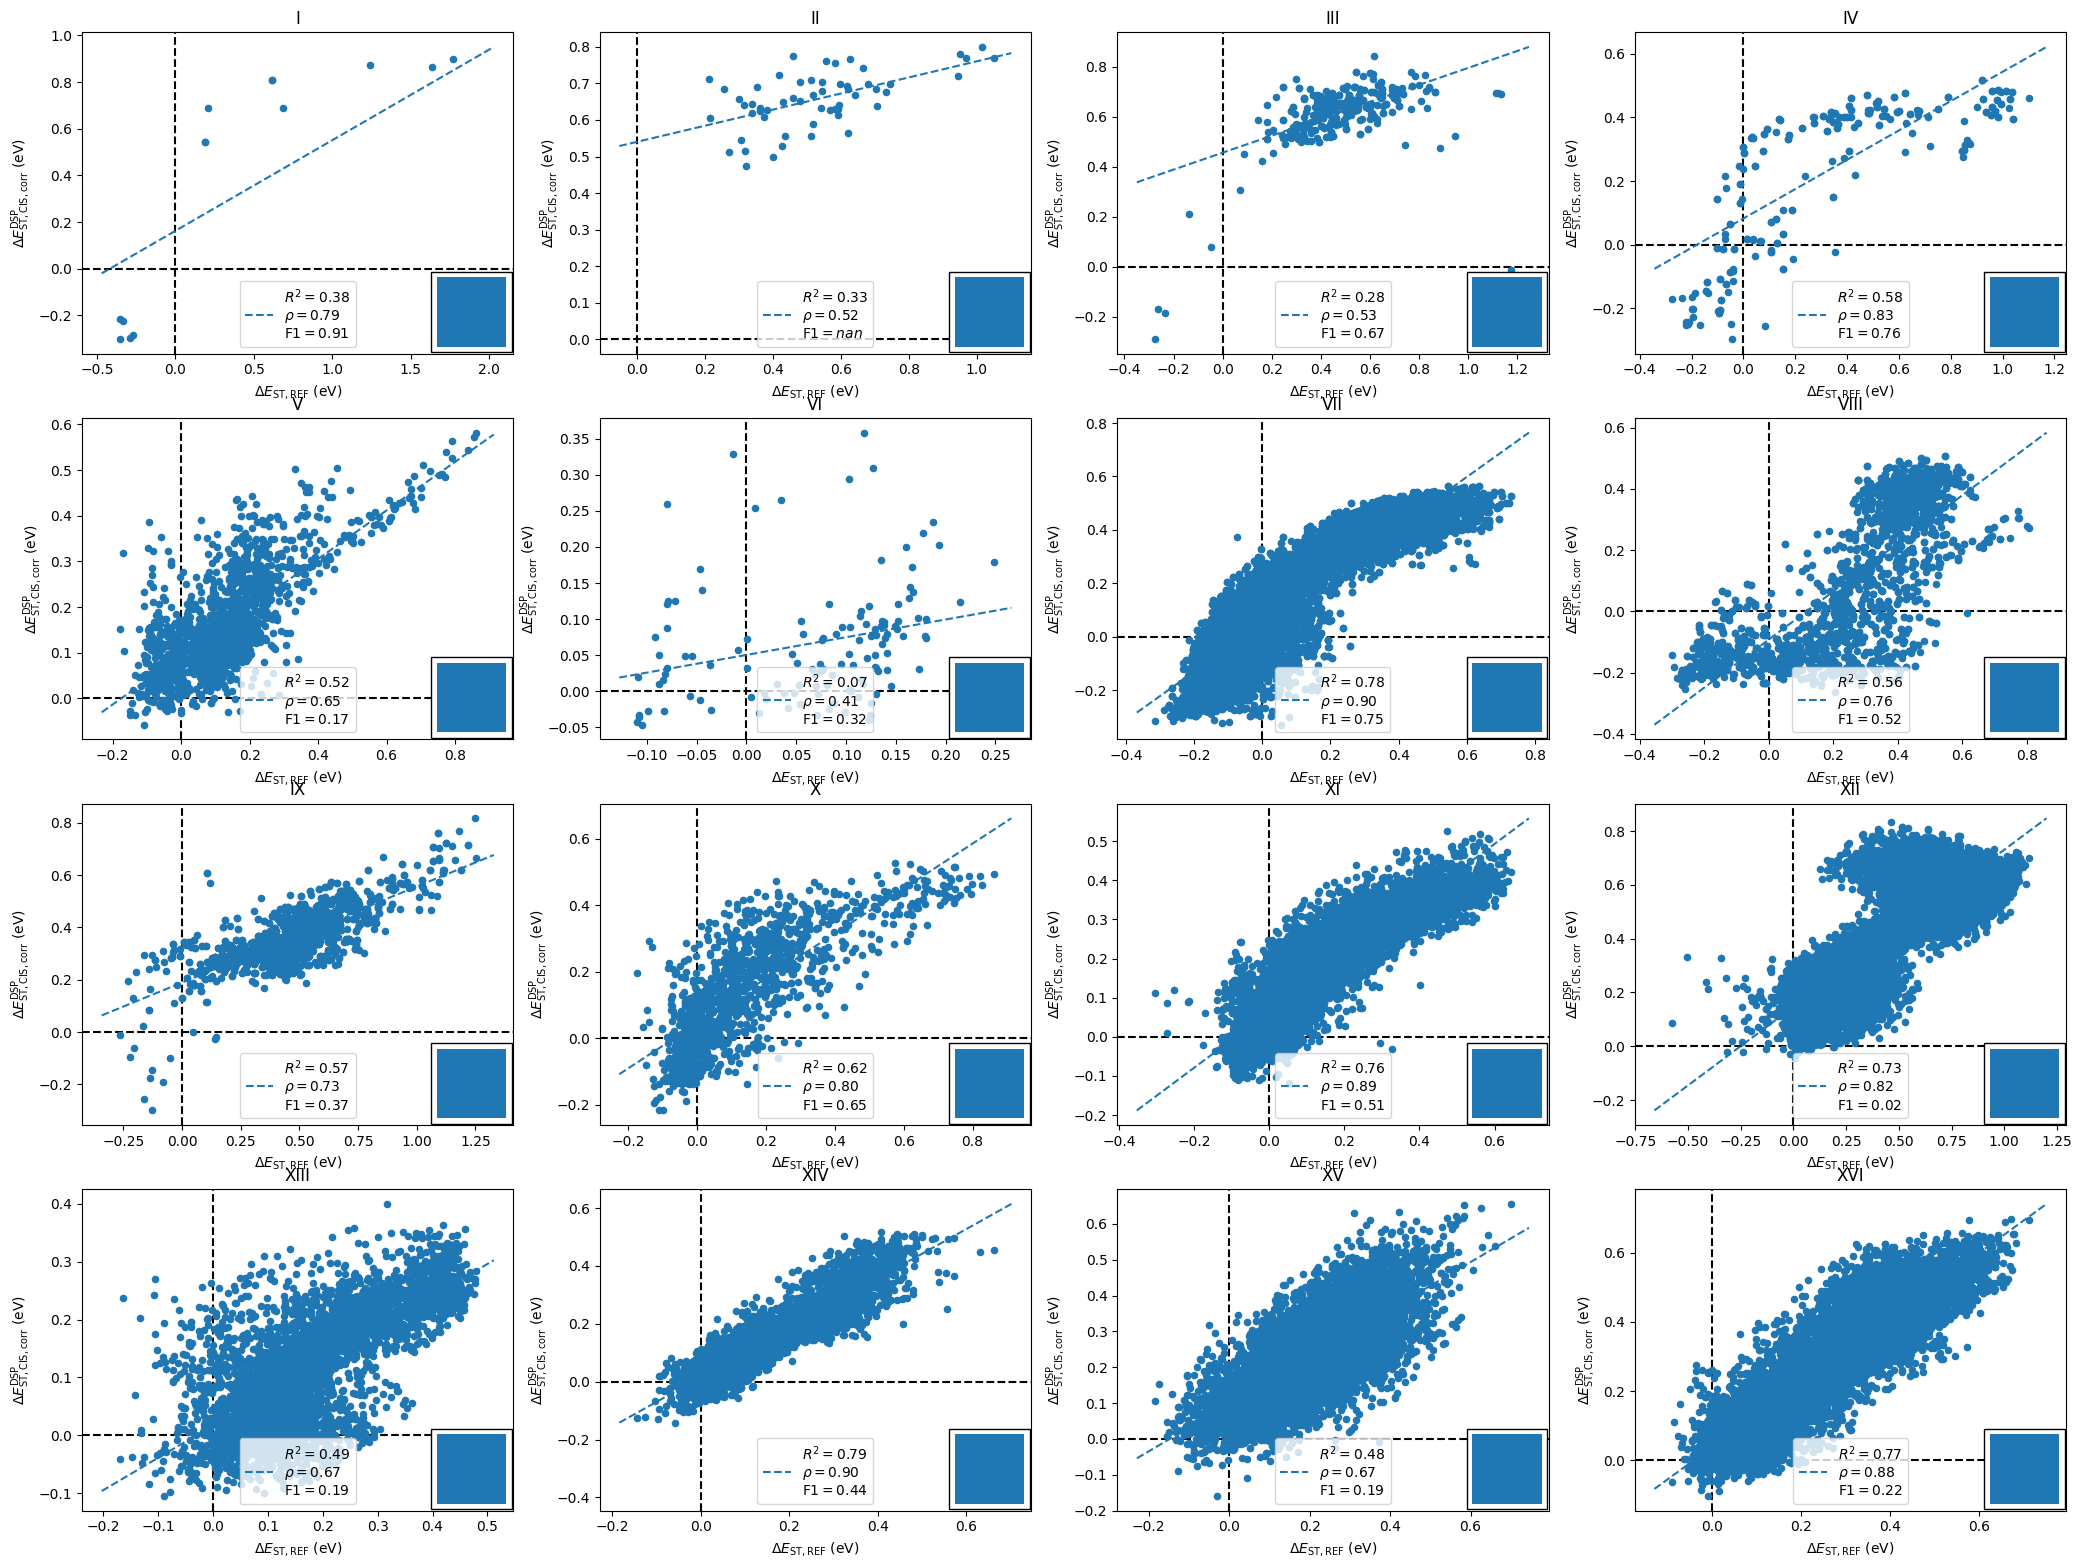

In [7]:
n_rows = 4
n_columns = 4
fig, axs = plt.subplots(
    n_columns,
    n_rows,
    figsize=plt.rcParams["figure.figsize"] * np.array([n_rows, n_columns]),
)

scaffolds = list(PARENT_SMILES.keys())
scaffold_svgs = {}
scaffold_results = {}
for i, scaffold in enumerate(scaffolds):
    df = df_rational[df_rational["scaffold"] == scaffold]
    i_row = i // n_rows
    i_col = i % n_columns
    ax = axs[i_row, i_col]
    smiles = PARENT_SMILES[scaffold]
    mol = Chem.MolFromSmiles(smiles)
    mol_image = draw_mol(mol, img_format="svg")

    _, _, results = plot_zero_zero(
        df,
        x_name="t1_s1_ref",
        y_name="t1_s1_dsp_cis_corr",
        plot_type="scatter",
        **plot_kwargs,
        fig=fig,
        ax=ax,
        legend_loc="lower center",
    )
    scaffold_results[scaffold] = results
    ax.set_title(scaffold)
    skunk_label = f"sk_{i}"

    box = skunk.Box(50, 50, gid=skunk_label)
    ab = AnnotationBbox(
        box, (1, 0), xycoords="axes fraction", box_alignment=(1.1, -0.1)
    )
    ax.add_artist(ab)
    scaffold_svgs[skunk_label] = mol_image

# Insert SVGs of molecules
svg = skunk.insert(scaffold_svgs)
png = cairosvg.svg2png(bytestring=svg, dpi=300, background_color="white")
png_cropped = crop_image(png)

path_figure = snakemake.output.figure_global_scaffolds_gap
with open(path_figure, "wb") as f:
    f.write(png_cropped)
variables[f"fig_global_scaffolds_gaps"] = "../" + str(Path(path_figure).with_suffix(""))

In [8]:
# Add variables to be saved
for scaffold, results in scaffold_results.items():
    variables = add_to_variables(
        variables,
        results,
        label_calculation=label_calculation,
        label_compound="scaffolds_gap",
        label_method=scaffold,
    )

# Add parameters to be saved
path_table = snakemake.output.table_global_scaffolds
params[f"tab_global_scaffolds"] = "../" + path_table

# Print tables for the paper
df = pd.DataFrame(scaffold_results).T
floatfmt = [None] + [".2f"] * (df.shape[1] - 4) + [".0f"] * 4
df.replace(np.nan, None).to_markdown(path_table, floatfmt=floatfmt, missingval="-")

In [9]:
for metric in (r"$R^2$", "Recall"):
    values = [d[metric] for d in scaffold_results.values()]
    idx_min = np.nanargmin(values)
    idx_max = np.nanargmax(values)
    value_min = np.nanmin(values)
    value_max = np.nanmax(values)
    scaffold_name_max = SCAFFOLD_NAMES[scaffolds[idx_max]].lower()
    scaffold_name_min = SCAFFOLD_NAMES[scaffolds[idx_min]].lower()
    results = {
        f"{metric}_max": value_max,
        f"{metric}_min": value_min,
        f"{metric}_max_name": scaffold_name_max,
        f"{metric}_min_name": scaffold_name_min,
    }

    variables = add_to_variables(
        variables,
        results,
        label_calculation=label_calculation,
        label_compound="scaffolds",
        label_method="",
    )

In [10]:
n_captured = sum(
    [
        (results["Recall"] > 0) and ~np.isnan(results["ROC-AUC"])
        for results in scaffold_results.values()
    ]
)
variables["global_scaffolds_n_captured"] = n_captured

Plot oscillator strengths for all the scaffolds

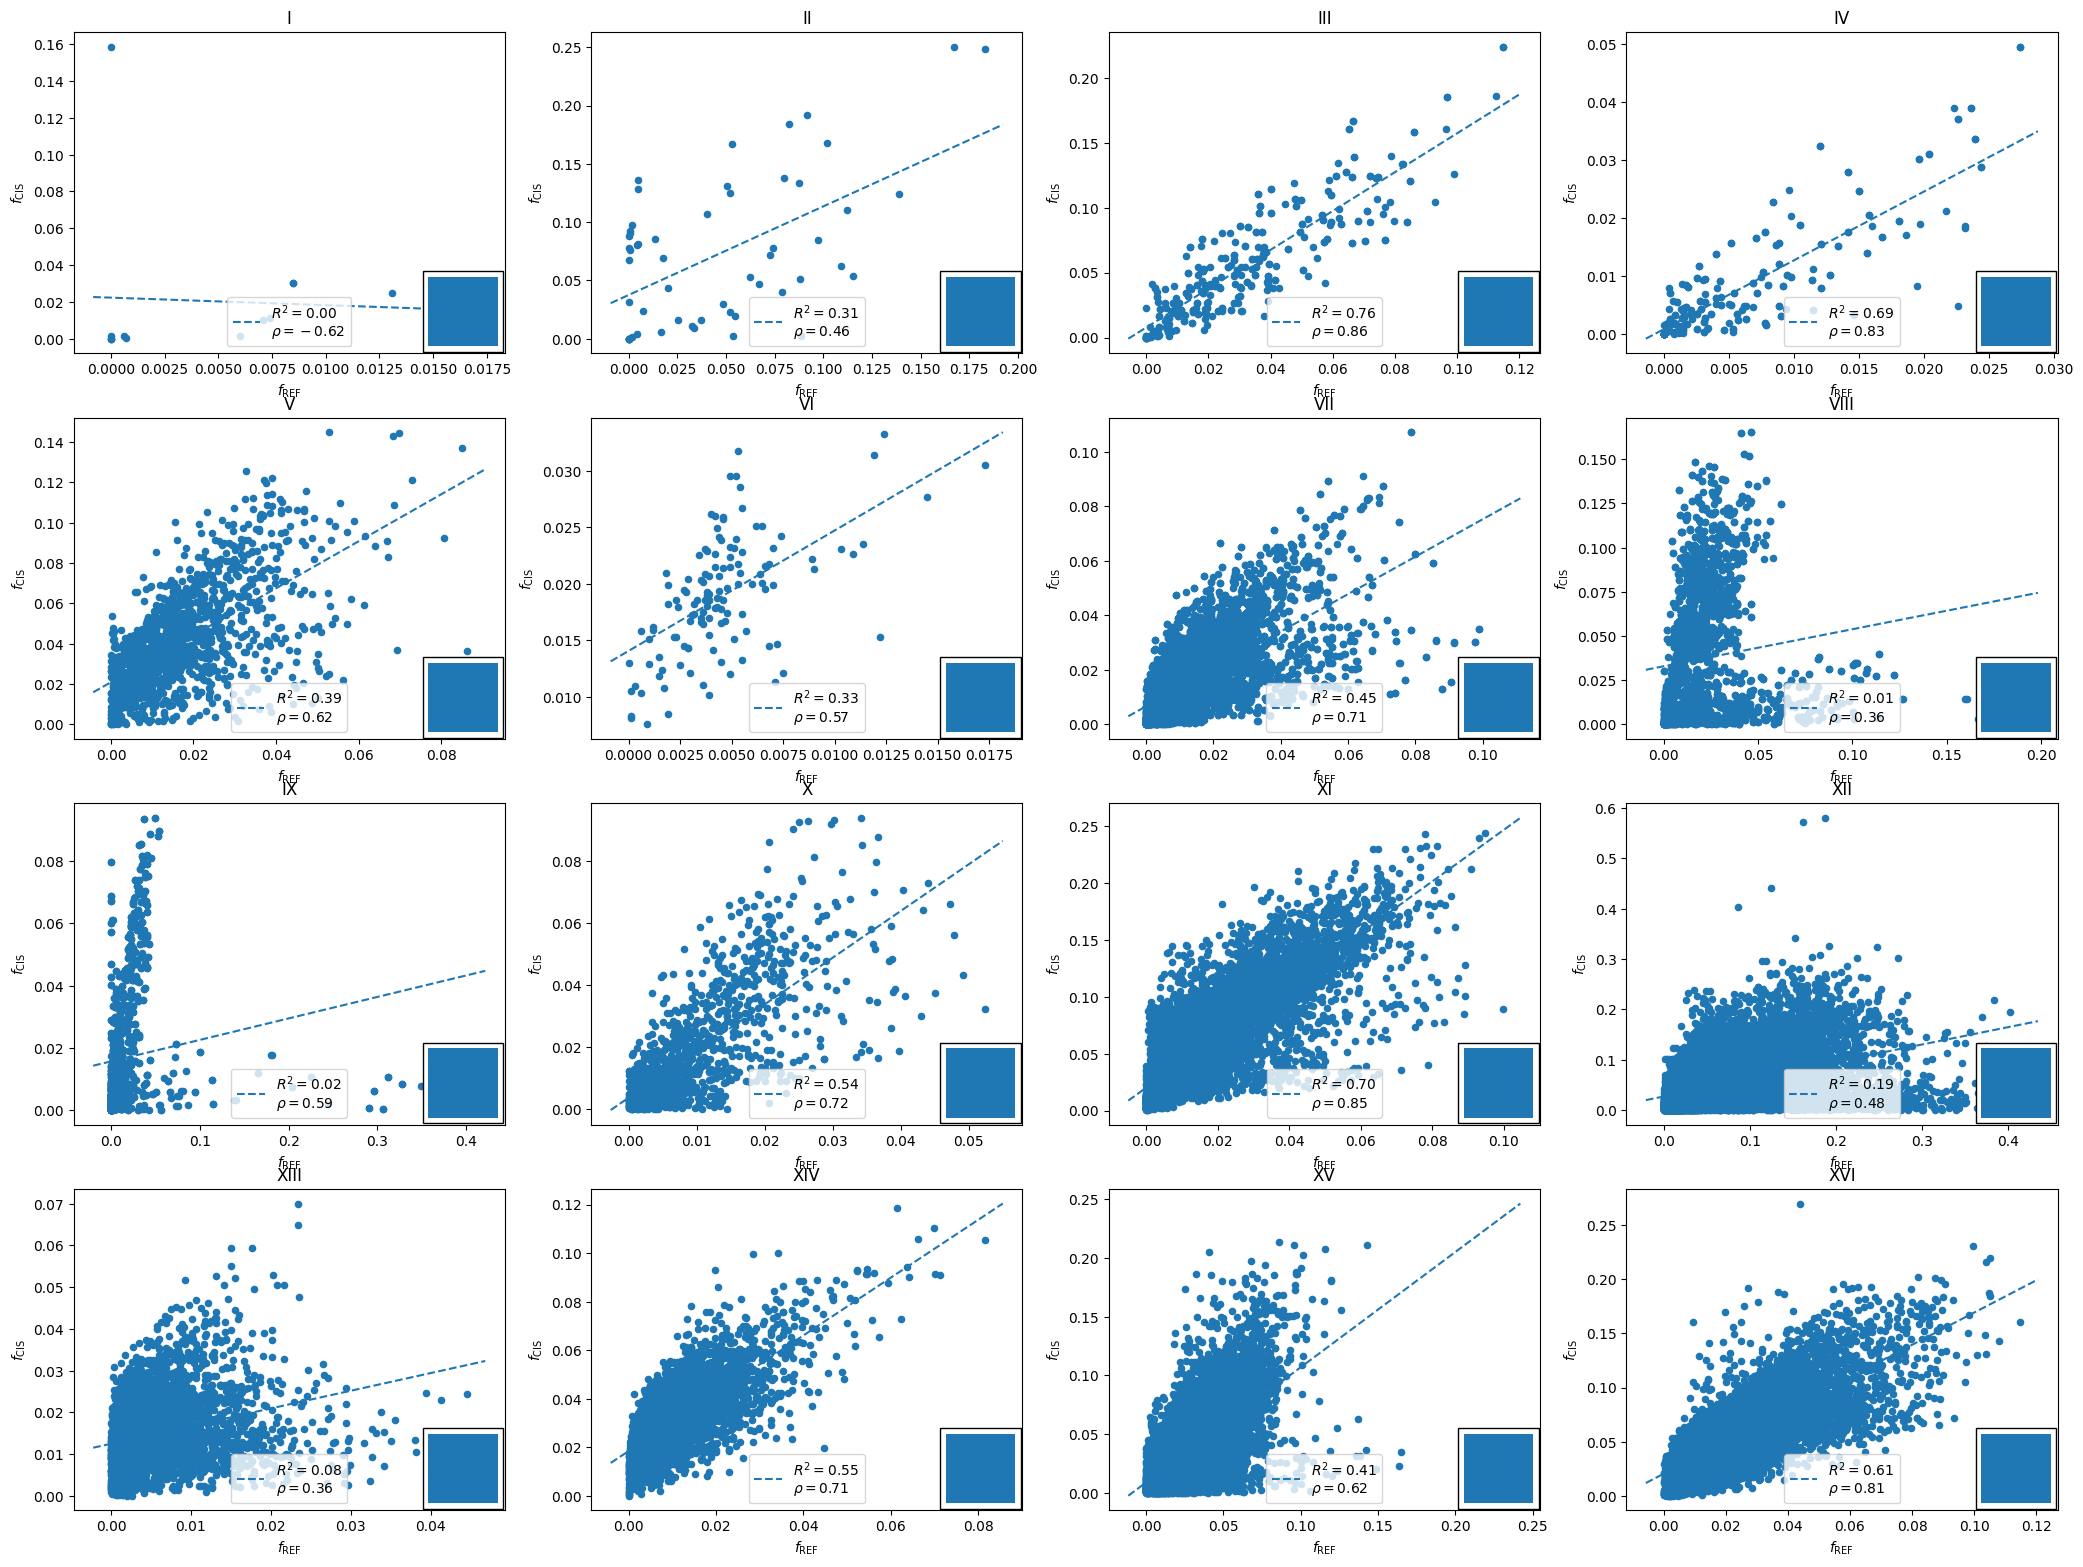

In [11]:
n_rows = 4
n_columns = 4
fig, axs = plt.subplots(
    n_columns,
    n_rows,
    figsize=plt.rcParams["figure.figsize"] * np.array([n_rows, n_columns]),
)
plot_kwargs = {"edgecolors": "black", "linewidths": 0.5}

scaffolds = list(PARENT_SMILES.keys())
scaffold_svgs = {}
scaffold_results = {}
for i, scaffold in enumerate(scaffolds):
    df = df_rational[df_rational["scaffold"] == scaffold]
    i_row = i // n_rows
    i_col = i % n_columns
    ax = axs[i_row, i_col]
    smiles = PARENT_SMILES[scaffold]
    mol = Chem.MolFromSmiles(smiles)
    mol_image = draw_mol(mol, img_format="svg")

    _, _, results = plot_zero_zero(
        df,
        x_name="oscillator_strength_ref",
        y_name="oscillator_strength",
        plot_type="scatter",
        **plot_kwargs,
        ax=ax,
        legend_loc="lower center",
        zero_zero=False,
    )
    scaffold_results[scaffold] = results
    ax.set_title(scaffold)
    skunk_label = f"sk_{i}"

    box = skunk.Box(50, 50, gid=skunk_label)
    ab = AnnotationBbox(
        box, (1, 0), xycoords="axes fraction", box_alignment=(1.1, -0.1)
    )
    ax.add_artist(ab)
    scaffold_svgs[skunk_label] = mol_image

# Add variables to be saved
for scaffold, results in scaffold_results.items():
    variables = add_to_variables(
        variables,
        results,
        label_calculation=label_calculation,
        label_compound="scaffolds_oscillator",
        label_method=scaffold,
    )

# Insert SVGs of molecules
svg = skunk.insert(scaffold_svgs)
png = cairosvg.svg2png(bytestring=svg, dpi=300, background_color="white")
png_cropped = crop_image(png)


path_figure = snakemake.output.table_global_scaffolds_oscillator
with open(path_figure, "wb") as f:
    f.write(png_cropped)
variables[f"fig_global_scaffolds_oscillator"] = "../" + str(
    Path(path_figure).with_suffix("")
)

Plot singlet excitation energies for the scaffolds

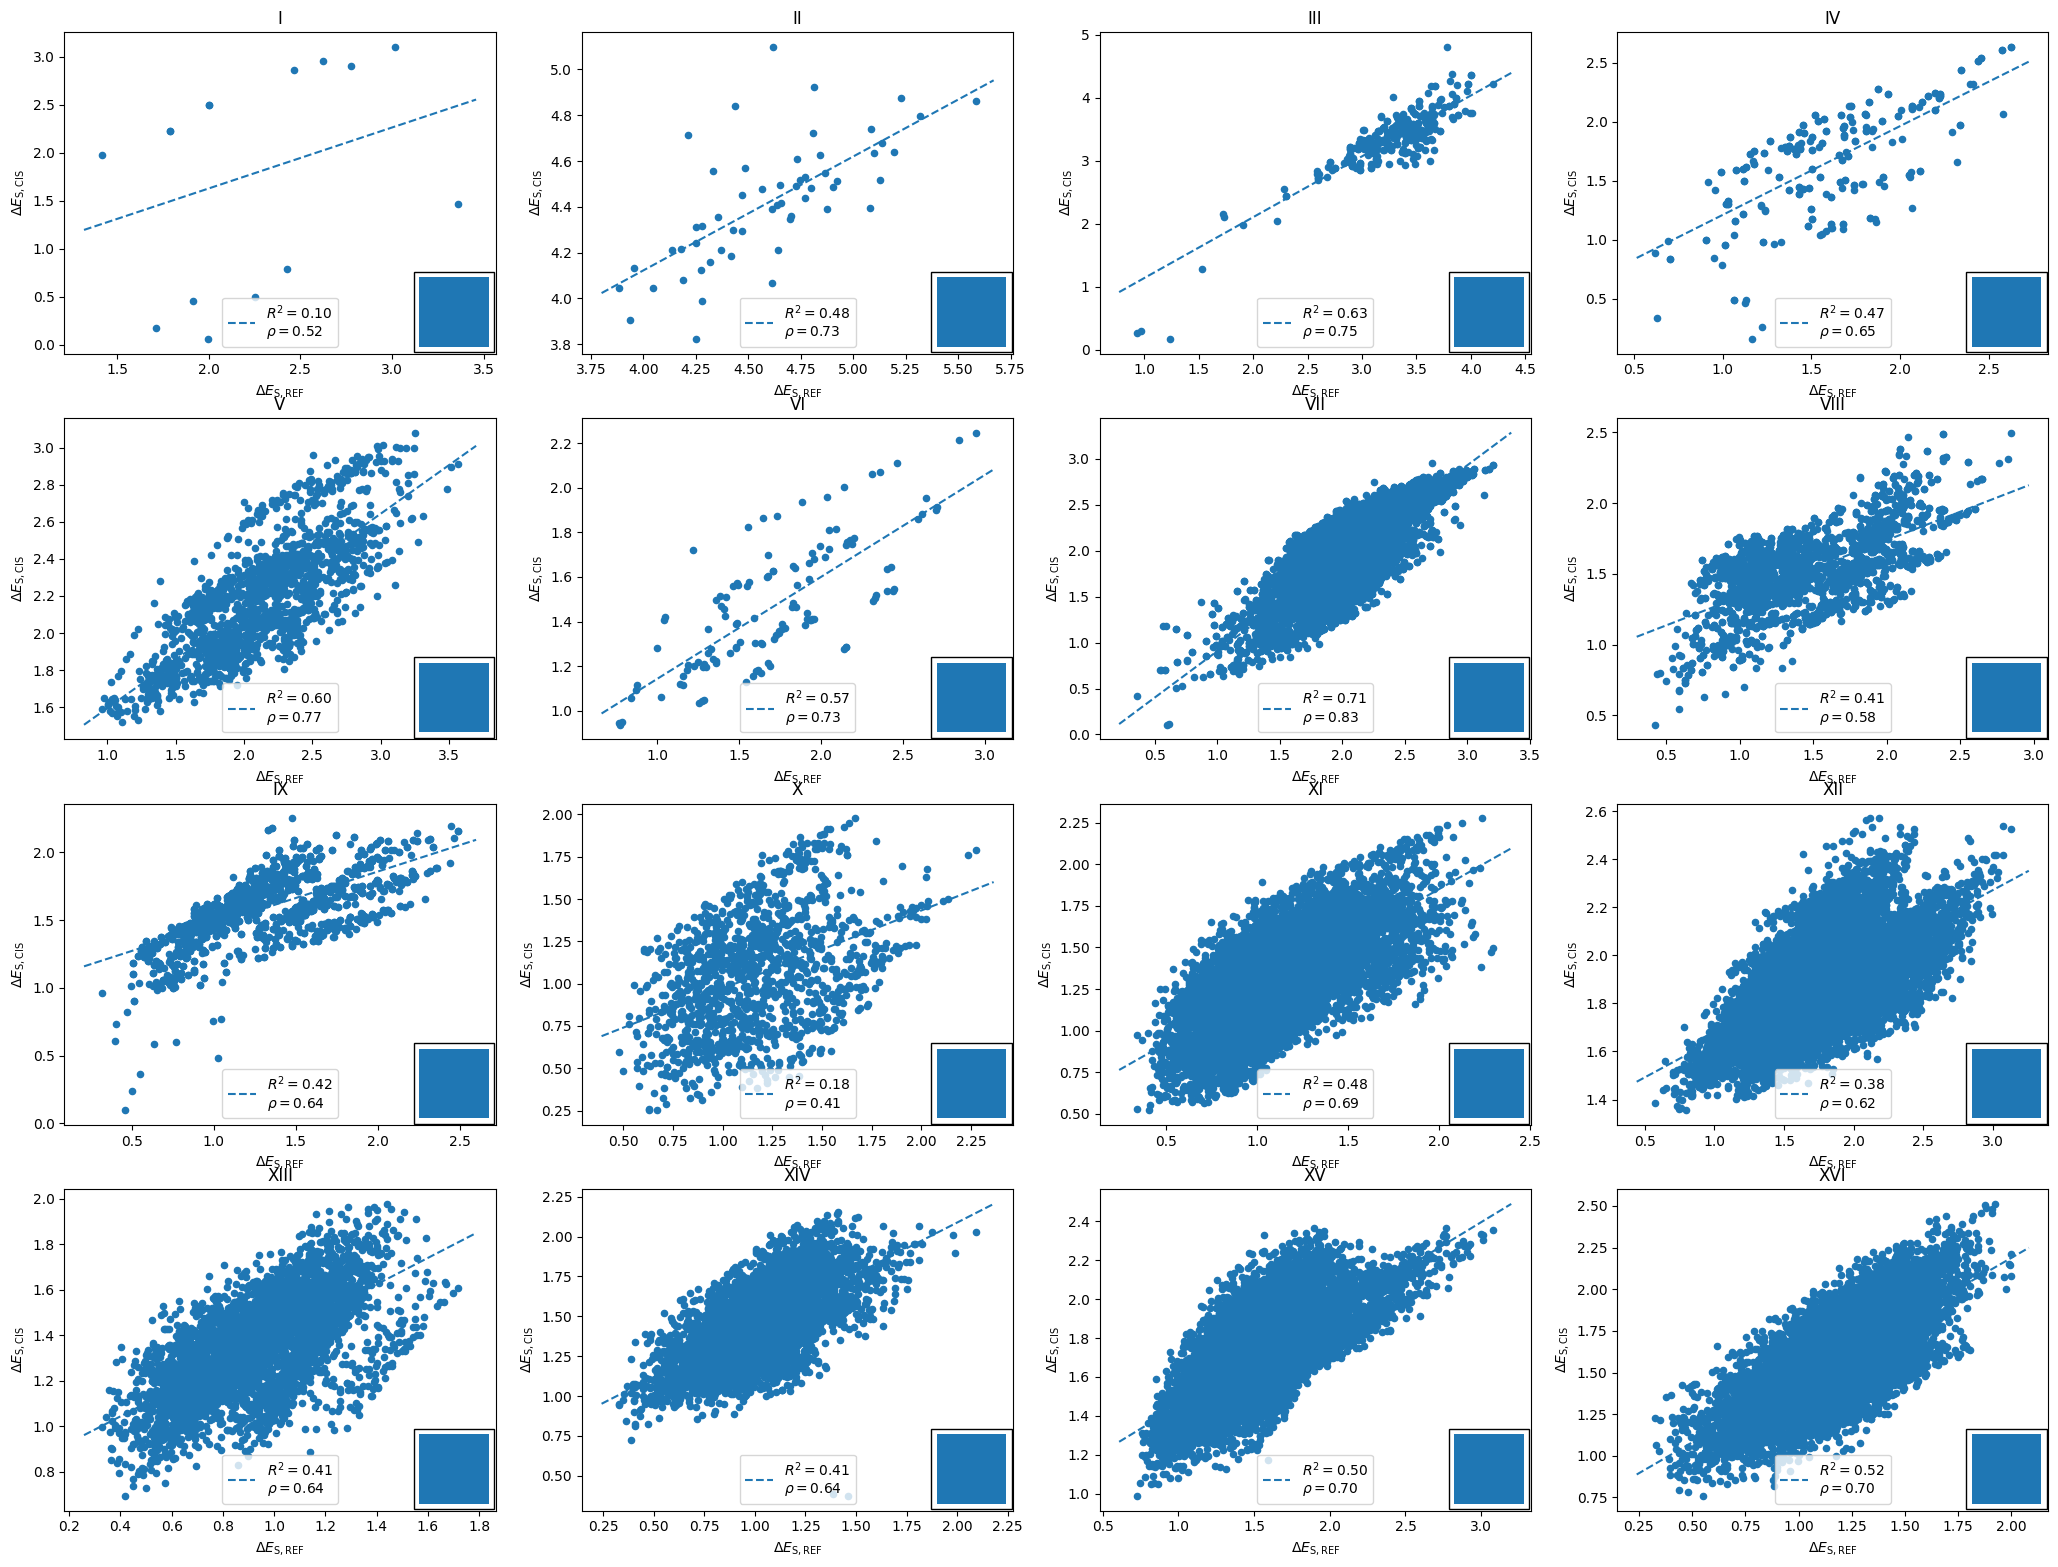

In [12]:
n_rows = 4
n_columns = 4
fig, axs = plt.subplots(
    n_columns,
    n_rows,
    figsize=plt.rcParams["figure.figsize"] * np.array([n_rows, n_columns]),
)

scaffolds = list(PARENT_SMILES.keys())
scaffold_svgs = {}
scaffold_results = {}
for i, scaffold in enumerate(scaffolds):
    df = df_rational[df_rational["scaffold"] == scaffold]
    i_row = i // n_rows
    i_col = i % n_columns
    ax = axs[i_row, i_col]
    smiles = PARENT_SMILES[scaffold]
    mol = Chem.MolFromSmiles(smiles)
    mol_image = draw_mol(mol, img_format="svg")

    _, _, results = plot_zero_zero(
        df,
        x_name="s1_ref",
        y_name="s1_cis",
        plot_type="scatter",
        zero_zero=False,
        **plot_kwargs,
        ax=ax,
        legend_loc="lower center",
    )
    scaffold_results[scaffold] = results
    ax.set_title(scaffold)
    skunk_label = f"sk_{i}"

    box = skunk.Box(50, 50, gid=skunk_label)
    ab = AnnotationBbox(
        box, (1, 0), xycoords="axes fraction", box_alignment=(1.1, -0.1)
    )
    ax.add_artist(ab)
    scaffold_svgs[skunk_label] = mol_image

# Add variables to be saved
for scaffold, results in scaffold_results.items():
    variables = add_to_variables(
        variables,
        results,
        label_calculation=label_calculation,
        label_compound="scaffolds_singlet",
        label_method=scaffold,
    )

# Insert SVGs of molecules
svg = skunk.insert(scaffold_svgs)
png = cairosvg.svg2png(bytestring=svg, dpi=300, background_color="white")
png_cropped = crop_image(png)


path_figure = snakemake.output.figure_global_scaffolds_singlet
with open(path_figure, "wb") as f:
    f.write(png_cropped)
variables[f"fig_global_scaffolds_singlet"] = "../" + str(
    Path(path_figure).with_suffix("")
)

Plot triplet excitation energies for the scaffolds

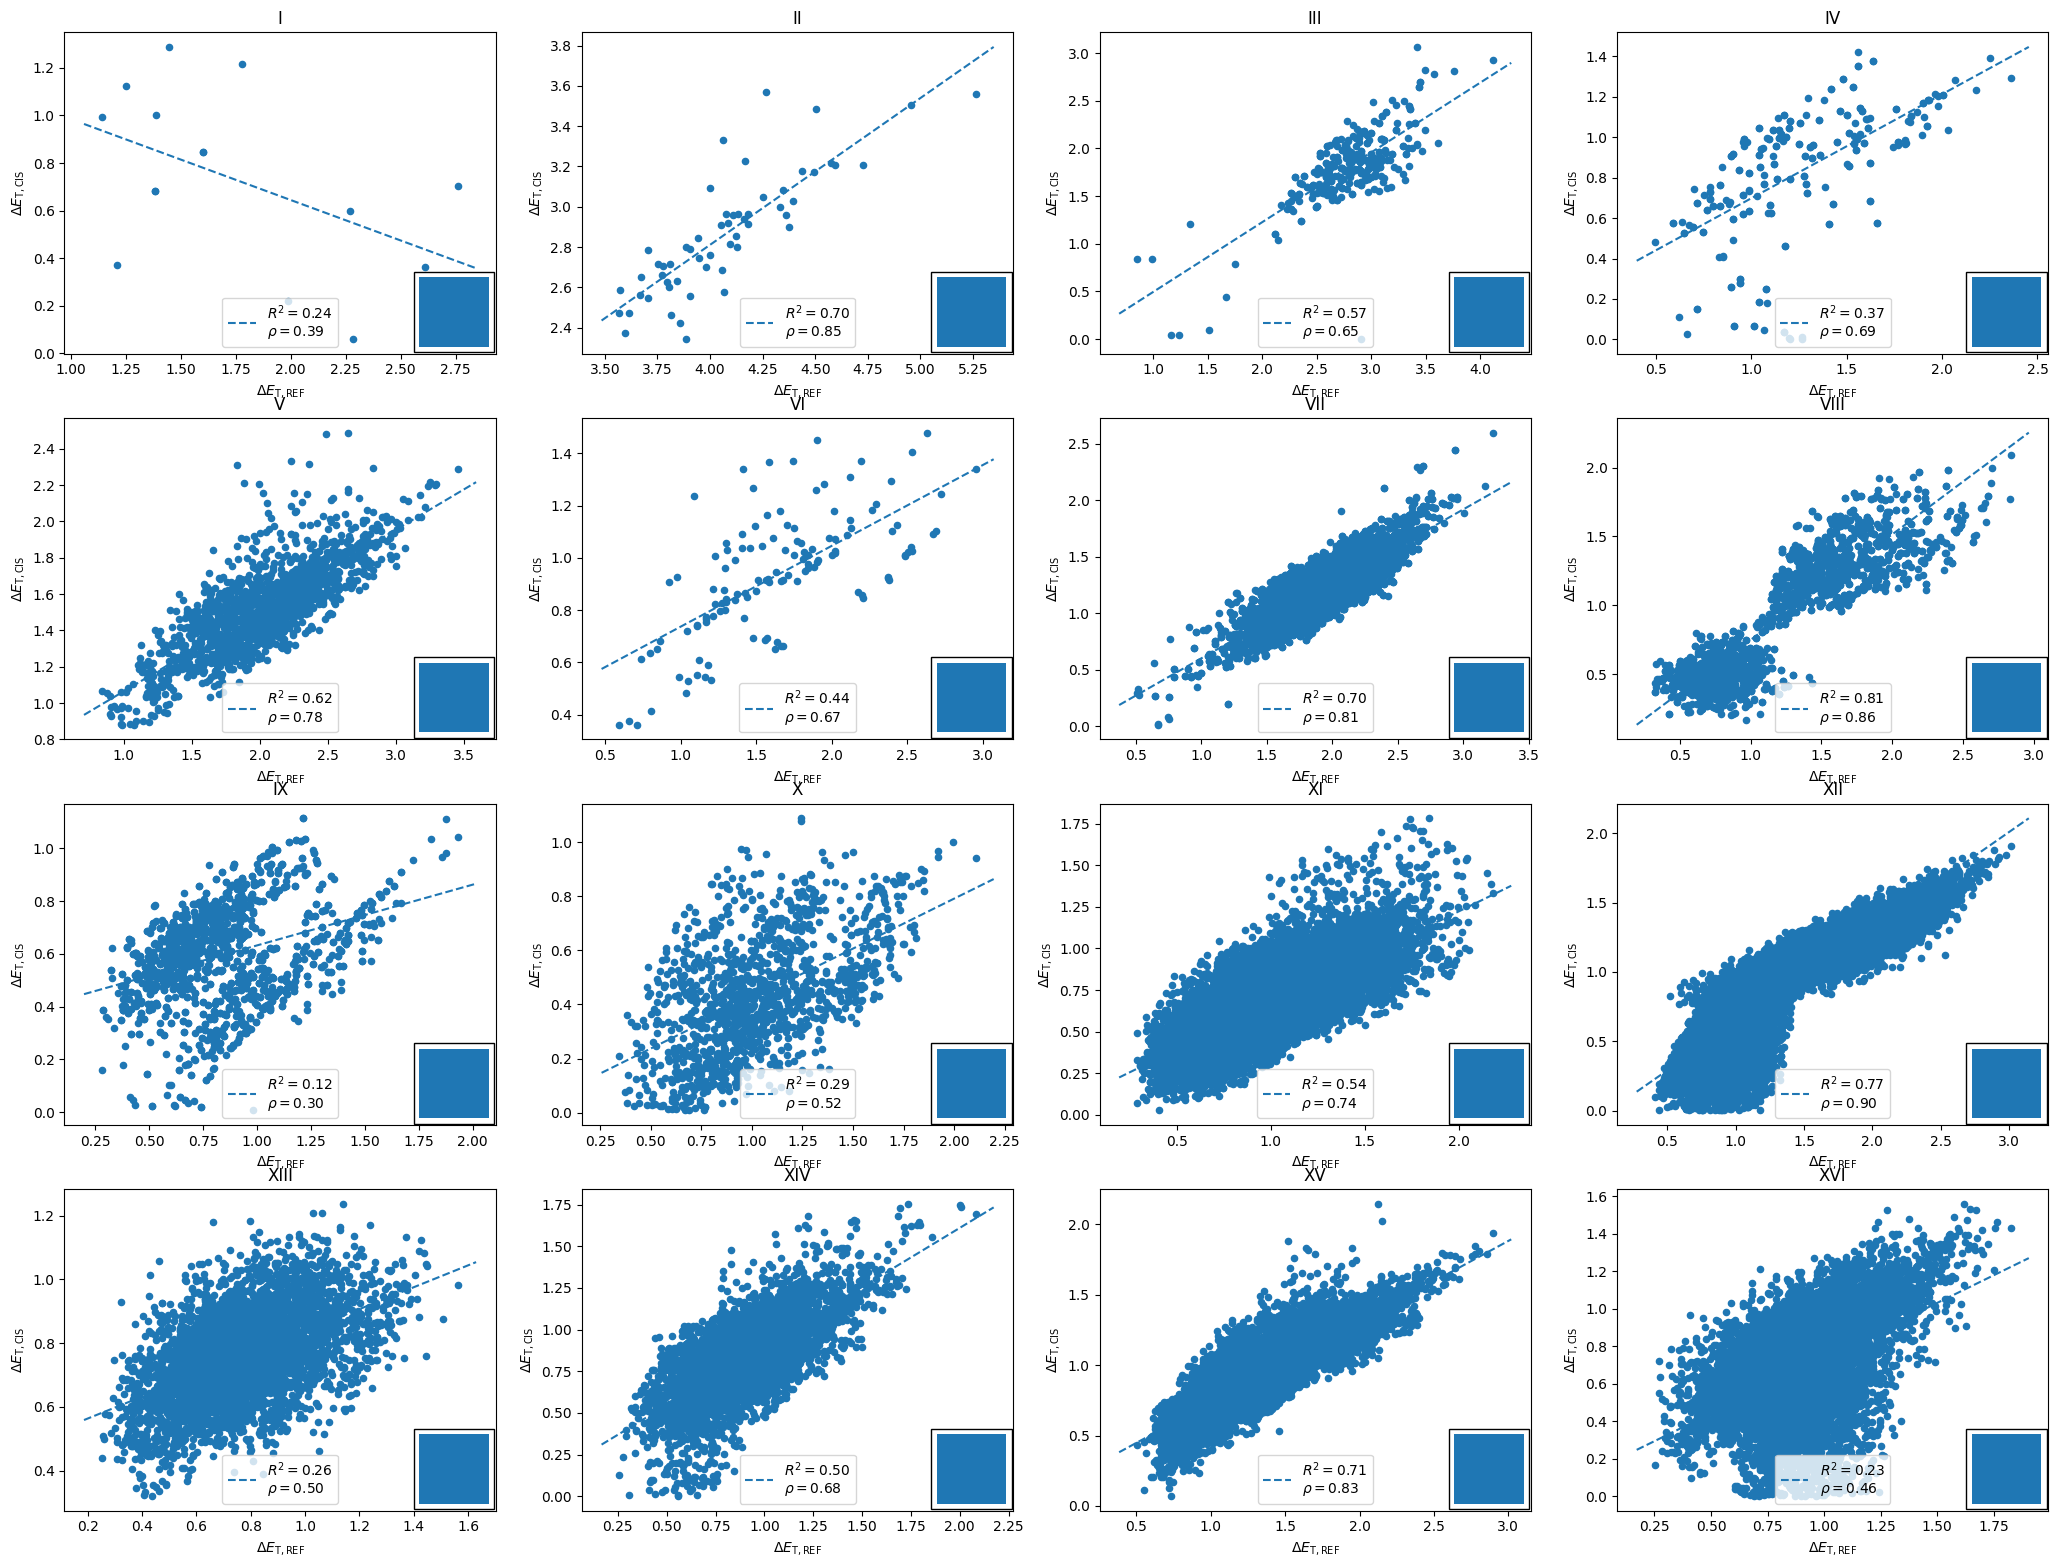

In [13]:
n_rows = 4
n_columns = 4
fig, axs = plt.subplots(
    n_columns,
    n_rows,
    figsize=plt.rcParams["figure.figsize"] * np.array([n_rows, n_columns]),
)

scaffolds = list(PARENT_SMILES.keys())
scaffold_svgs = {}
scaffold_results = {}
for i, scaffold in enumerate(scaffolds):
    df = df_rational[df_rational["scaffold"] == scaffold]
    i_row = i // n_rows
    i_col = i % n_columns
    ax = axs[i_row, i_col]
    smiles = PARENT_SMILES[scaffold]
    mol = Chem.MolFromSmiles(smiles)
    mol_image = draw_mol(mol, img_format="svg")

    _, _, results = plot_zero_zero(
        df,
        x_name="t1_ref",
        y_name="t1_cis",
        plot_type="scatter",
        zero_zero=False,
        **plot_kwargs,
        ax=ax,
        legend_loc="lower center",
    )
    scaffold_results[scaffold] = results
    ax.set_title(scaffold)
    skunk_label = f"sk_{i}"

    box = skunk.Box(50, 50, gid=skunk_label)
    ab = AnnotationBbox(
        box, (1, 0), xycoords="axes fraction", box_alignment=(1.1, -0.1)
    )
    ax.add_artist(ab)
    scaffold_svgs[skunk_label] = mol_image

# Add variables to be saved
for scaffold, results in scaffold_results.items():
    variables = add_to_variables(
        variables,
        results,
        label_calculation=label_calculation,
        label_compound="scaffolds_triplet",
        label_method=scaffold,
    )

# Insert SVGs of molecules
svg = skunk.insert(scaffold_svgs)
png = cairosvg.svg2png(bytestring=svg, dpi=300, background_color="white")
png_cropped = crop_image(png)


path_figure = snakemake.output.figure_global_scaffolds_triplet
with open(path_figure, "wb") as f:
    f.write(png_cropped)
variables[f"fig_global_scaffolds_triplet"] = "../" + str(
    Path(path_figure).with_suffix("")
)

Save the parameters and variables to file

In [14]:
with open(snakemake.output.params, "w") as f:
    yaml.dump(format_dictionary_for_yaml(params, n_dec=2), f)
with open(snakemake.output.variables, "w") as f:
    yaml.dump(format_dictionary_for_yaml(variables, n_dec=2), f)